In [1]:
%load_ext autoreload
%autoreload 2

import os
import warnings
import sys

warnings.filterwarnings('ignore')
from tensorflow import logging
logging.set_verbosity(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

In [ ]:
sys.path.append('..')
from pydens import Solver, NumpySampler, cart_prod, add_tokens, plot_loss, plot_sections_2d
add_tokens()

# Constants & system of equations

* Q1: What are the scales of variables? Is, say, $p_o$ is measured in hundreds or hundreds of millions?
* Q2: What is the time-range?

<tr>
<td> <img src="params_1.png" alt="Drawing" style="width: 500px; height: 550px"/> </td>
<td> <img src="params_2.png" alt="Drawing" style="width: 500px; height: 200px"/> </td>
</tr>

In [3]:
m = (0.1 + 0.3) / 2
g = 9.81

k_o = (0.1 + 10) / 2
mu_o = (0.5 + 1) / 2
b_o = (1.1 + 1.5) / 2
rho_o = (750 + 950) / 2
coeff_o = k_o / (mu_o*b_o)
Q_o = 10 #(10 + 500) / 2

k_w = (0.1 + 10) / 2
mu_w = (0.2 + 12) / 2
b_w = (1.0 + 1.02) / 2
rho_w = (980 + 1040) / 2
coeff_w = k_w / (mu_w*b_w)
Q_w = 10 #(10 + 500) / 2

theta = (0.01 + 0.03) / 2
a = (-0.25 - 0.05) / 2
c = (-2 - 4) / 2

$\textbf{Note}$: the equation is set up only with $x$and $t$, we get rid of $y$ and $z$ for simplicity

<img src="equations.png" alt="Drawing" style="width: 400px; height: 150px"/>

In [61]:
p_ow = lambda s_w: (2*theta / np.sqrt(k_o/m)) / (a*(1 - s_w)/(1 + c*s_w))
eq_1 = lambda p_w, s_w, x, t: div(coeff_o*D(p_w + p_ow(s_w)), length=1) - ((m / b_o)*D(1 -пьф s_w, t)
                                                                           + 40*Q_o*x*(1-x))
eq_2 = lambda p_w, s_w, x, t: div(coeff_w*D(p_w), length=1) - ((m / b_w)*D(s_w, t)
                                                               + 40*Q_w*x*(1-x))

In [62]:
initial_condition = [[200], [0.7]]

## Training `PyDEns`-model

In [63]:
pde = {'n_dims': 2, 'n_funs': 2, 'n_eqns': 2,
       'form': [eq_1,
                eq_2],
       'initial_condition': initial_condition,
       'time_multiplier': 'sigmoid'}

# Put it all together in model-config
config = {'pde': pde,
          'decay': {'name': 'invtime', 'learning_rate': 0.05,
                    'decay_steps': 100, 'decay_rate': 0.05},
          'track': {'p_w': lambda p_w, s_w, x, t: p_w,
                    'p_o': lambda p_w, s_w, x, t: p_w + p_ow(s_w),
                    's_w': lambda p_w, s_w, x, t: s_w,
                    's_o': lambda p_w, s_w, x, t: 1 - s_w}}

# Uniform sampling scheme
s = NumpySampler('u', dim=2)

In [64]:
# train the network on batches of 100 points
dg = Solver(config, layer_size=35)
dg.fit(batch_size=500, sampler=s, n_iters=1000, bar='notebook')

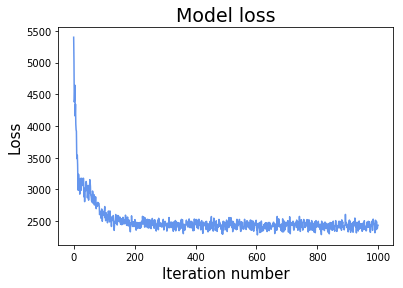

In [65]:
# Plot loss
plot_loss(dg.loss, color='cornflowerblue')

# Time-sections of approximate solutions

# $P_w$

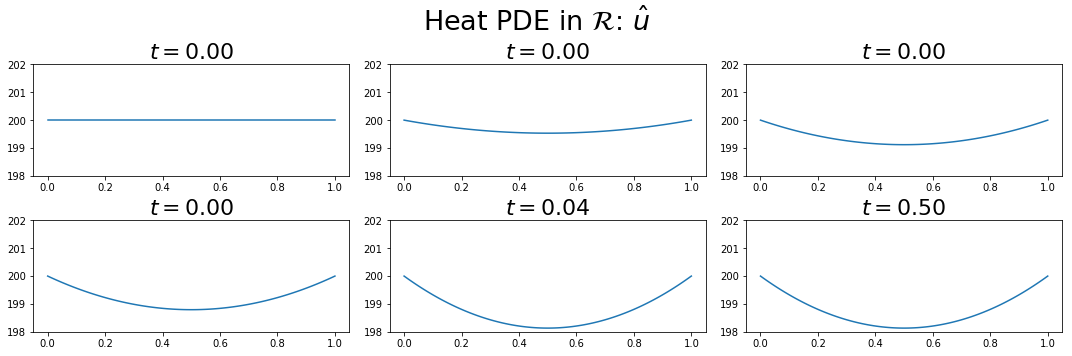

In [72]:
plot_sections_2d(dg, fetches='p_w', ylim=(198.0, 202.0),
                 timestamps=(0, 0.001, 0.002, 0.003, 0.04, 0.5))

# $P_o$

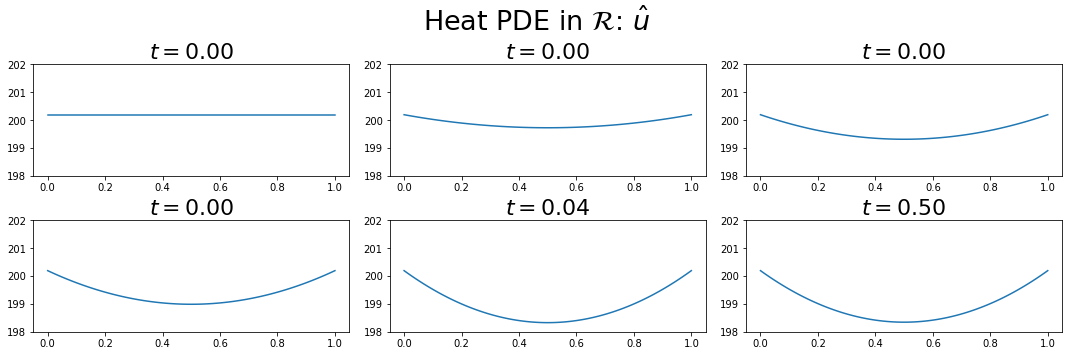

In [73]:
plot_sections_2d(dg, fetches='p_o', ylim=(198, 202),
                 timestamps=(0, 0.001, 0.002, 0.003, 0.04, 0.5))

# $S_o$

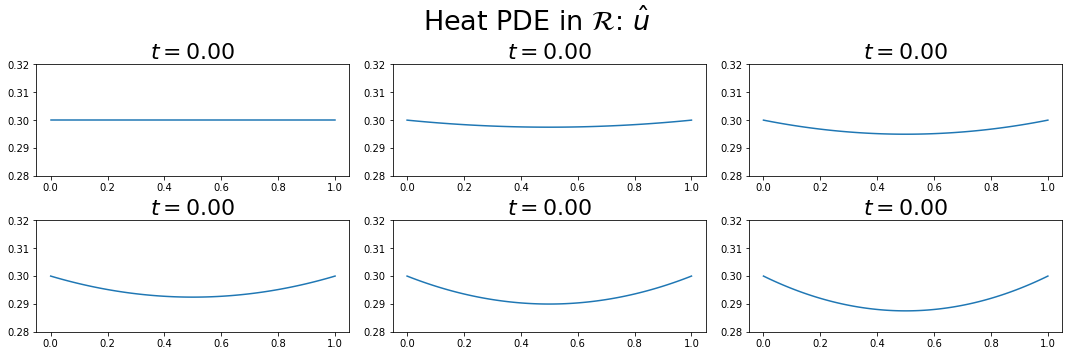

In [51]:
plot_sections_2d(dg, fetches='s_o', ylim=(0.28, 0.32),
                 timestamps=(0, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005))

# $S_w$

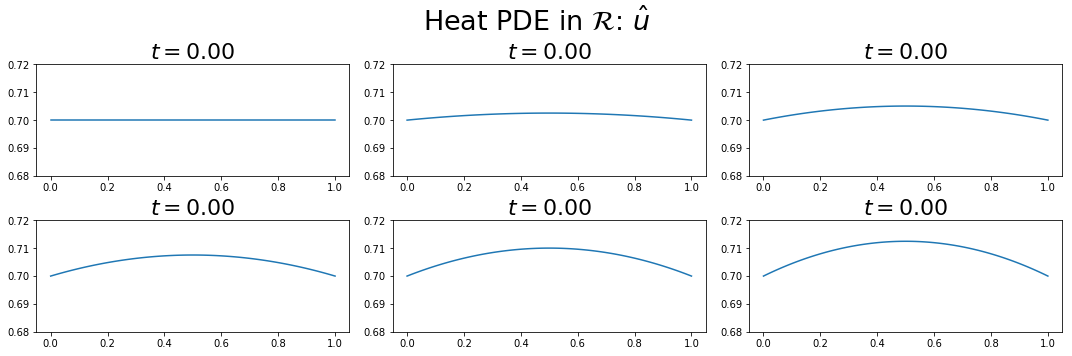

In [52]:
plot_sections_2d(dg, fetches='s_w', ylim=(0.68, .72),
                 timestamps=(0, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005))